<a href="https://www.kaggle.com/code/mariuszcha/pytorch-under-the-hood?scriptVersionId=132790317" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In the provided notebook, you will discover a PyTorch implementation and a clear numpy implementation for solving the MNIST dataset problem. Initially, binary classification is performed, and subsequently, it transitions into multi-class classification. One of the challenging aspects was comprehending the chain rule during the process of backward propagation. Understanding the construction of PyTorch classes is valuable for creating new classes in the future, extending the functionality of existing ones.


**Importing libraries...**

In [1]:
# Basic ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Used to PyTorch approach
import torch
import torch.nn as nn

**Data preparation...**

In [2]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

# We perform binary classification, so we select only records where label is 1 or 7.
fdata = data.loc[(data.label == 1)|(data.label == 7),:].copy()

# In binary classification the labels should be 0 or 1; so we map these values to existing one Number 7 is label 0
# and Number 1 is 1.
fdata['label'].replace({1: 1, 7: 0}, inplace=True)

# We have to divide our set into train and valid subsets, we do that in a proportion 80/20.
proportion = int(fdata.shape[0] * 0.8)

# Splitting data...
X_train = fdata.iloc[:proportion,1:].values / 255.
X_valid = fdata.iloc[proportion:,1:].values / 255.
y_train = fdata.iloc[:proportion,0].values.reshape(-1,1)
y_valid = fdata.iloc[proportion:,0].values.reshape(-1,1)

# Here we prepare data for PyTorch model. PyTorch require tensors. Tensor is basically Matrix or Array but in PyTorch
# nomenclature.
X_train_t, X_valid_t, y_train_t, y_valid_t = map(torch.Tensor, (X_train, X_valid, y_train, y_valid))

In [3]:
# Here we define some parameters - both for our PyTorch approach and Numpy approach
input_size = X_train.shape[1]
hidden_size = 32
output_size = 1
epochs = 20
batch = 128
lr = 0.01

# Numpy approach:

Here, in the numpy approach, we define new classes such as Linear, ReLU, Sigmoid, and MAE (our loss function). These classes are designed to encapsulate specific operations and calculations within our model. By implementing the `__call__` method, we enable easy invocation of these objects as if they were functions.

The key aspect is the `backward` method, which plays a vital role in calculating gradients during the backward propagation step. It enables the flow of gradients through the network, allowing us to update the model's parameters based on the loss.

In summary, the numpy approach involves creating specialized classes that encapsulate different operations in the model. The `__call__` method allows these objects to be easily invoked, while the `backward` method is responsible for computing gradients and facilitating the backward propagation process.

The Model class is responsible for defining the architecture of our model. By encapsulating the architecture within a class, we can easily add new hidden layers and customize the structure of our neural network.

In order to train our model, we define a simple fit function that performs the backward propagation through multiple epochs. This function allows our neural network to learn from the data and update its parameters based on the defined loss function and optimization algorithm.

By organizing the model architecture and training process within the Model class, we can easily create instances of the model, customize its structure, and train it on different datasets. This approach provides a modular and flexible way to build and train neural networks.

Useful resources to backward propagation and calculation of gradients:
* [https://cs231n.github.io/optimization-2/](http://)
* [https://www.youtube.com/watch?v=Ilg3gGewQ5U](http://)
* [https://www.youtube.com/watch?v=tIeHLnjs5U8](http://)
* FSDL Course

**Some good questions...**

1. Why we multiply weights and biases by learning rate?
* The purpose of multiplying the gradients by the learning rate is to control the magnitude of the update. 
If the learning rate is too high, the updates to the parameters can be too large, causing the optimization process to overshoot the optimal solution and potentially lead to instability or divergence. On the other hand, if the learning rate is too low, the updates can be too small, leading to slow convergence and potentially getting stuck in suboptimal solutions.

2. How we calculate gradients and how it works?
* The first link above is fantastic explanation of importance of backpropagation and how exacly it works. Basically our architecture looks like this: INPUT -> HIDDEN LAYER(LINEAR1) -> ACTIVATION FUNCTION(RELU) -> HIDDEN LAYER(LINEAR 2) -> ACTIVATION FUNCTION(SIGMOID) -> OUTPUT LAYER - where we calculate Loss Function, in that situation it's MAE Error. For each of that steps we have to calculate gradient. Starting with MAE -> SIGMOID -> LINEAR 2 -> RELU -> LINEAR 1. We have to perform all of that calcs in order to update weights in biases in both Linear layers.
##### Let's start with LOSS(MAE):
Formula: **SUM(y_pred - y_true) / n**, where n number of samples\
Gradient: **SIGN(y_pred - y_true) / n**

In the gradient of MAE, we use the sign function to determine the direction of the gradient based on the difference between the predicted values and the true values. If the predicted value is greater than the true value, the difference will be positive, and the sign function will return 1, indicating that we need to decrease the predicted value. If the predicted value is smaller than the true value, the difference will be negative, and the sign function will return -1, indicating that we need to increase the predicted value.

By multiplying the sign of the difference with 1/n, we obtain the scaled gradient that points in the direction that minimizes the absolute difference between the predicted values and the true values. This scaled gradient is then used to update the parameters of the model during the optimization process.

##### Sigmoid:
Formula: **f = 1 /(1 + exp(-x))** \
Gradient: **(1 - f) * f**

In the first link (cs231) we can find perfect explanation of Sigmoid Gradient and how to simpify it to so basic form.

##### ReLU:
Formula: **MAX(x, 0)** \
Gradient: **x > 0** \
When differentiating the ReLU function, we only consider the case when x > 0 because the derivative of ReLU is constant and equal to 1 for positive values of x. For x <= 0, the derivative is 0, so the gradient is 0 in those cases. Therefore, the gradient of ReLU can be expressed as a Boolean mask (x > 0) that returns 1 if x > 0 and 0 otherwise. This simple gradient computation can be found in resources like the cs231n course notes.

##### Linear:
Formula: **y = wx + b** \
Gradient: \
dy/dx = w, gradient of x as our output in Chain Rule\
dy/dw = x, gradient for weight\
dy/db = 1, gradienf for bias\

Calculating gradients for Linear model we have three of them. dy/dw and dy/db are actual gradients used to update weights and biases in specific layer where dy/dx is output used in Chain Rule.\
As the name says - it is called Chain Rule - so each layer must be connected with other one. Basically the gradients flow thru our model to first hidden layer...

**Classes and functions...**

In [4]:
class Linear:
    def __init__(self, input_size, hidden_size):
        # Initalization of weights and biases using Xavier Initalizer in constructor
        variance = 1 / (input_size + hidden_size)
        std_dev = np.sqrt(variance)
        self.weights = np.random.randn(input_size, hidden_size) * std_dev
        self.bias = np.zeros(hidden_size)
  
    def __call__(self, x):
        # Simple linear model
        self.x = x
        output = x @ self.weights + self.bias
        return output

    def backward(self, input_gradient):
        # It is important to remember about proper shapes during multiplying. We can check them using .shape
        self.weights_gradient = self.x.T @ input_gradient
        self.bias_gradient = input_gradient.sum(axis=0)
        output_gradient = input_gradient @ self.weights.T
        return output_gradient

    def update(self, lr):
        self.weights -= lr * self.weights_gradient
        self.bias -= lr * self.bias_gradient
        
class ReLU:
    def __call__(self, x):
        self.x = x
        return np.maximum(x, 0)
    
    def backward(self, input_gradient):
        output_gradient = input_gradient * (self.x > 0)
        return output_gradient
        
class MAE:
    def __call__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return np.mean(np.abs(y_pred - y_true))

    def backward(self):
        n = self.y_true.shape[0]
        output_gradient = np.sign(self.y_pred - self.y_true) / n
        return output_gradient
    
class Sigmoid():
    def __call__(self, x):
        self.x = x
        return 1 / (1 + np.exp(-self.x))
    
    def backward(self, input_gradient):
        # At the beginning I had small problem with coding that backward prop for sigmoid. However we can use very clever
        # class feature. This line of code calculates the sigmoid value for the input self.x and assigns it to the 
        # sigmoid_output variable.
        sigmoid_output = self.__call__(self.x)
        output_gradient = input_gradient * sigmoid_output * (1 - sigmoid_output)
        return output_gradient
    
class Model:
    # Here we initalize instances of our above-created classes
    def __init__(self, input_size, hidden_size, output_size):
        self.linear1 = Linear(input_size, hidden_size)
        self.relu = ReLU()
        self.linear2 = Linear(hidden_size, output_size)
        self.sigmoid = Sigmoid()
  
    # We perform forward prop here, by connecting each layer and activation function together
    def __call__(self, x):
        l1 = self.linear1(x)
        r = self.relu(l1)
        l2 = self.linear2(r)
        sig = self.sigmoid(l2)
        return sig
  
    # Here we perform backward propagation
    def backward(self, loss_gradient):
        sigmoid_gradient = self.sigmoid.backward(loss_gradient)
        linear2_gradient = self.linear2.backward(sigmoid_gradient)
        relu_gradient = self.relu.backward(linear2_gradient)
        linear1_gradient = self.linear1.backward(relu_gradient)
        return linear1_gradient
    
    # Updating weights and biases for Linear layers
    def update(self, lr):
        self.linear2.update(lr)
        self.linear1.update(lr)

# Simple fit function to perform multiple epochs
def fit(loss, model, epochs, lr, bs, x, y):
    loss_tracker = []
    data_size = x.shape[0]
    batch_num = (data_size + bs - 1) // bs
    for epoch in range(epochs):
        for batch_idx in range(batch_num):
            
            start_idx = batch_idx * bs
            end_idx = min((batch_idx + 1) * bs, data_size)
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            
            y_pred = model(x_batch)
            loss_value = loss(y_pred, y_batch)
            loss_gradient = loss.backward()
            model.backward(loss_gradient)
            model.update(lr)
            
        print(f'Epoch {epoch}, Loss {loss_value},', 'Accuracy', np.round((y == (model(x) >= .5)).mean()*100),'%')
        loss_tracker.append(loss(model(x),y))
    plt.plot(loss_tracker)

# Predicting on validation set
def predict(model, x, y):
    predictions = model(x)
    print('Accuracy on valid set: ', np.round((y == (predictions >= .5)).mean()*100),'%')

**Creating instances of classes and calling functions...**

Epoch 0, Loss 0.3948559406730051, Accuracy 58.0 %
Epoch 1, Loss 0.3235292635699109, Accuracy 87.0 %
Epoch 2, Loss 0.2699756697396359, Accuracy 95.0 %
Epoch 3, Loss 0.21683990200078707, Accuracy 97.0 %
Epoch 4, Loss 0.16633459108733678, Accuracy 98.0 %
Epoch 5, Loss 0.1281002494980553, Accuracy 98.0 %
Epoch 6, Loss 0.1024322835331865, Accuracy 98.0 %
Epoch 7, Loss 0.08511400511466997, Accuracy 98.0 %
Epoch 8, Loss 0.07290660099747875, Accuracy 98.0 %
Epoch 9, Loss 0.06392817289298819, Accuracy 98.0 %
Epoch 10, Loss 0.05704176866978592, Accuracy 98.0 %
Epoch 11, Loss 0.05159518856276095, Accuracy 98.0 %
Epoch 12, Loss 0.04718566379765532, Accuracy 98.0 %
Epoch 13, Loss 0.04354815432699393, Accuracy 98.0 %
Epoch 14, Loss 0.040503731688432666, Accuracy 98.0 %
Epoch 15, Loss 0.037908509173103073, Accuracy 98.0 %
Epoch 16, Loss 0.03568293623834255, Accuracy 98.0 %
Epoch 17, Loss 0.03375185890953411, Accuracy 99.0 %
Epoch 18, Loss 0.032062451932348794, Accuracy 99.0 %
Epoch 19, Loss 0.0305736

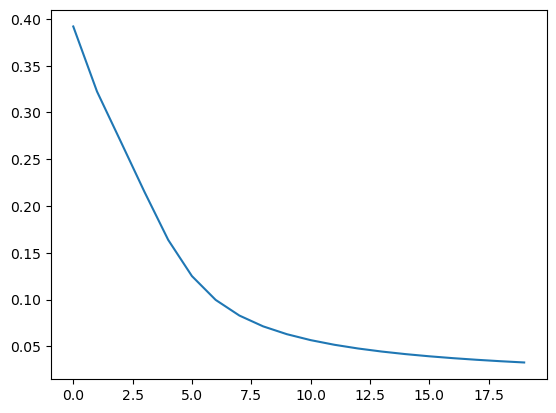

In [5]:
loss = MAE()
model = Model(input_size, hidden_size, output_size)
fit(loss, model, epochs, lr, batch, X_train, y_train)
predict(model, X_valid, y_valid)

As we can notice on plot and output above, our model performs quite well on train and valid data.

# PyTorch torch:

We will built right now the same model but using fantastic PyTorch, as you will notice it's much simplier and faster but it's essential to know how classes in PyTorch library actually works. 

In [6]:
class NNetwork(nn.Module):
    # We create instances of required functions to our architecture
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    # In numpy approach we called it __call__ method but here it is forward, but the way it works is similar
    def forward(self, x):
        l1 = self.linear1(x)
        r = self.relu(l1)
        l2 = self.linear2(r)
        sig = self.sigmoid(l2)
        return sig
    
    # We dont have backward propagation here. PyTorch calculates gradients automatically.
    
# Simple function to fit using multiple epochs.
def torch_fit(loss, model, optim, epochs, bs, lr, x, y):
    for epoch in range(epochs):
        data_size = x.shape[0]
        batch_num = (data_size + bs - 1) // bs
        for batch_idx in range(batch_num):
            
            start_idx = batch_idx * bs
            end_idx = min((batch_idx + 1) * bs, data_size)
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            
            # It is necessary to zero our gradients after every epoch, otherwise we would accumulate them.
            optim.zero_grad()
            y_pred = model(x_batch)
            loss_value = loss(y_pred, y_batch)
            # Calculating gradients
            loss_value.backward()
            # Param update
            optim.step()
            
        print(f'Epoch {epoch}, loss {loss_value},', 'accuracy', np.round((y.numpy() == (model(x).detach().numpy() >= .5)).mean()*100),'%')

def torch_predict(model, x, y):
    model.eval()
    predictions = model(x)
    print('Accuracy', np.round((y.numpy() == (predictions.detach().numpy() >= .5)).mean()*100),'%')

**Creating instances and calling functions...**

In [7]:
torchLoss = nn.L1Loss()
torchModel = NNetwork(input_size, hidden_size, output_size)
# Here we use SGD optimizer which updates our parameters in model. We call method parameters() which is inherited from
# nn.Module.
torchOptimizer = torch.optim.SGD(torchModel.parameters(), lr=lr)
    
torch_fit(torchLoss, torchModel, torchOptimizer, epochs, batch, lr, X_train_t, y_train_t)
torch_predict(torchModel, X_valid_t, y_valid_t)

Epoch 0, loss 0.46023669838905334, accuracy 89.0 %
Epoch 1, loss 0.4006425142288208, accuracy 96.0 %
Epoch 2, loss 0.3218463659286499, accuracy 97.0 %
Epoch 3, loss 0.24052639305591583, accuracy 97.0 %
Epoch 4, loss 0.1761099249124527, accuracy 97.0 %
Epoch 5, loss 0.13324280083179474, accuracy 97.0 %
Epoch 6, loss 0.10574472695589066, accuracy 97.0 %
Epoch 7, loss 0.08745312690734863, accuracy 98.0 %
Epoch 8, loss 0.07457593083381653, accuracy 98.0 %
Epoch 9, loss 0.06506490707397461, accuracy 98.0 %
Epoch 10, loss 0.05778956785798073, accuracy 98.0 %
Epoch 11, loss 0.052049264311790466, accuracy 98.0 %
Epoch 12, loss 0.04741648584604263, accuracy 98.0 %
Epoch 13, loss 0.04360123723745346, accuracy 98.0 %
Epoch 14, loss 0.04041097313165665, accuracy 98.0 %
Epoch 15, loss 0.037707436829805374, accuracy 98.0 %
Epoch 16, loss 0.03538685664534569, accuracy 98.0 %
Epoch 17, loss 0.03337917849421501, accuracy 98.0 %
Epoch 18, loss 0.03162747249007225, accuracy 98.0 %
Epoch 19, loss 0.030087

As we can see - that model performs as well as numpy approach.

**Accessing model weights, biases, architecture...**

We can see matrix of weights and biases for each of our Linear Layer. These are final weights and biases used in predicting on validation set.

In [8]:
for name, param in torchModel.named_parameters():
    print(name, param)

linear1.weight Parameter containing:
tensor([[-0.0263, -0.0340, -0.0218,  ..., -0.0323,  0.0206,  0.0290],
        [-0.0322,  0.0063, -0.0066,  ..., -0.0037, -0.0017, -0.0148],
        [-0.0135,  0.0267,  0.0157,  ..., -0.0008,  0.0341,  0.0208],
        ...,
        [ 0.0016,  0.0242,  0.0181,  ..., -0.0114, -0.0228,  0.0079],
        [-0.0002,  0.0015,  0.0075,  ..., -0.0098,  0.0271,  0.0289],
        [ 0.0354, -0.0197, -0.0044,  ..., -0.0261,  0.0206,  0.0074]],
       requires_grad=True)
linear1.bias Parameter containing:
tensor([ 0.0119, -0.0182,  0.0113,  0.0229,  0.0863, -0.0212,  0.0292,  0.0497,
         0.0272,  0.0297,  0.0345,  0.0154,  0.0451, -0.0223, -0.0032,  0.0562,
         0.0586,  0.0908, -0.0064,  0.0219,  0.0565, -0.0104,  0.0403,  0.0392,
         0.0281,  0.0025, -0.0352,  0.0545, -0.0040,  0.0334,  0.0498,  0.0133],
       requires_grad=True)
linear2.weight Parameter containing:
tensor([[-0.1047,  0.1852, -0.0356, -0.3326,  0.5103, -0.1267,  0.1349, -0.4160,
 

In [9]:
display(torchModel.parameters) # Accessing architecture
display(torchModel.linear1.weight.data) # Accessing weights in first hidden layer. We see it is similar to weights above

<bound method Module.parameters of NNetwork(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)>

tensor([[-0.0263, -0.0340, -0.0218,  ..., -0.0323,  0.0206,  0.0290],
        [-0.0322,  0.0063, -0.0066,  ..., -0.0037, -0.0017, -0.0148],
        [-0.0135,  0.0267,  0.0157,  ..., -0.0008,  0.0341,  0.0208],
        ...,
        [ 0.0016,  0.0242,  0.0181,  ..., -0.0114, -0.0228,  0.0079],
        [-0.0002,  0.0015,  0.0075,  ..., -0.0098,  0.0271,  0.0289],
        [ 0.0354, -0.0197, -0.0044,  ..., -0.0261,  0.0206,  0.0074]])

# Multi-class classification:

not finished;
TO DO;
* Create CrossEntropyLoss
* Create Softmax

In [10]:
num_classes = 10
Xst = torch.Tensor(data.iloc[:proportion,1:].values / 255.)
Yst = torch.Tensor(np.eye(num_classes)[data.iloc[:proportion,0].values])
Xsv = torch.Tensor(data.iloc[proportion:,1:].values / 255.)
Ysv = torch.Tensor(np.eye(num_classes)[data.iloc[proportion:,0].values])

In [11]:
class NNetworkMC(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
  
    def forward(self, x):
        l1 = self.linear1(x)
        r = self.relu(l1)
        l2 = self.linear2(r)
        sm = self.softmax(l2)
        return sm
    
def Ttorch_fit(loss, model, optim, epochs, bs, lr, x, y):
    for epoch in range(epochs):
        data_size = x.shape[0]
        batch_num = (data_size + bs - 1) // bs
        for batch_idx in range(batch_num):
            
            start_idx = batch_idx * bs
            end_idx = min((batch_idx + 1) * bs, data_size)
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            
            optim.zero_grad()
            y_pred = model(x_batch)
            loss_value = loss(y_pred, y_batch)
            loss_value.backward()
            optim.step()
        print(f'Epoch {epoch}, loss {loss_value},', 'accuracy', np.round((model(x).detach().numpy().argmax(axis=1) == y.detach().numpy().argmax(axis=1)).mean()*100),'%')

    
TtorchLoss = nn.CrossEntropyLoss()
TtorchModel = NNetworkMC(input_size, hidden_size, 10)
TtorchOptimizer = torch.optim.SGD(TtorchModel.parameters(), lr=lr)
Ttorch_fit(TtorchLoss, TtorchModel, TtorchOptimizer, epochs, batch, lr, Xst, Yst)


Epoch 0, loss 2.3018083572387695, accuracy 14.0 %
Epoch 1, loss 2.300825595855713, accuracy 15.0 %
Epoch 2, loss 2.299755811691284, accuracy 16.0 %
Epoch 3, loss 2.298585891723633, accuracy 17.0 %
Epoch 4, loss 2.2973339557647705, accuracy 18.0 %
Epoch 5, loss 2.2959446907043457, accuracy 19.0 %
Epoch 6, loss 2.2944486141204834, accuracy 20.0 %
Epoch 7, loss 2.2928011417388916, accuracy 21.0 %
Epoch 8, loss 2.291002035140991, accuracy 23.0 %
Epoch 9, loss 2.289017915725708, accuracy 24.0 %
Epoch 10, loss 2.286821126937866, accuracy 25.0 %
Epoch 11, loss 2.2844088077545166, accuracy 25.0 %
Epoch 12, loss 2.2817578315734863, accuracy 26.0 %
Epoch 13, loss 2.278806686401367, accuracy 26.0 %
Epoch 14, loss 2.2754933834075928, accuracy 26.0 %
Epoch 15, loss 2.2717554569244385, accuracy 27.0 %
Epoch 16, loss 2.2675774097442627, accuracy 27.0 %
Epoch 17, loss 2.262911796569824, accuracy 27.0 %
Epoch 18, loss 2.257718086242676, accuracy 27.0 %
Epoch 19, loss 2.2520477771759033, accuracy 27.0 %